In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import os
from matplotlib.pyplot import MultipleLocator

In [2]:
base_time = pd.Timestamp('2018-01-01')

In [3]:
p_ls = os.listdir('./real/data/processed')
for i in range(len(p_ls)):
    p_ls[i] = int(p_ls[i].split('.')[0])
p_ls.sort()
p_ls
for p in p_ls:
    label = pd.read_csv(f'./real/data/processed/{p}.csv')
    label['ts'] = label['ts'].map(lambda x: pd.Timedelta(minutes=x) + base_time)
    label.to_csv(f'./real/data/processed_1/{p}.csv')

In [4]:
def loss_func(prediction, label):
    return np.sqrt(np.nanmean(np.square(prediction - label)))/np.sqrt(np.nanmean(np.square(label)))

In [5]:
def show_sample_cgm(result, idx, silence=False):
    sample = result['df'][idx].copy()
    sample['ts'] = sample['ts'].map(lambda x: pd.Timedelta(minutes=x) + base_time)
     
    sample['prediction'] *= 100.0
    sample['label'] *= 100.0
    sample['cgm'] *= 100.0
    
    infer_start_time = sample[sample['infer'] == 1]['ts'].min()
    
    patient_id = int(sample['patient_id'].iloc[0])
    
    print('Patient ID: ', patient_id)
    
    label = pd.read_csv(f'./real/data/processed_1/{patient_id}.csv')
    label['ts'] = pd.to_datetime(label['ts'])
    label = label[['ts', 'cgm', 'finger_stick', 'basal', 'bolus', 'meal']]
    
    sample = sample.merge(label, on='ts', how='inner').set_index('ts')[['label', 'prediction', 'finger_stick', 'cgm_x', 'cgm_y', 'infer', 'basal', 'bolus', 'meal']]
   
    if not silence:
        display(sample)
    
        fig, ax = plt.subplots(figsize=(20, 10))

        ax.axvline(infer_start_time, linestyle='--', color='black')
        sample[['label', 'prediction']].dropna().plot(ax=ax, style='o', markersize=8)
        sample[['cgm_x', 'cgm_y']].dropna().plot(ax=ax, linestyle='dashed')
        sample[['basal', 'bolus', 'meal']].plot(ax=ax, style='o', markersize=8)
    
    loss = loss_func(np.array(sample['cgm_x'],dtype=float), np.array(sample['cgm_y'],dtype=float))
    
    return sample, infer_start_time, loss

In [6]:
def show_sample_finger(result, idx, silence=False):
    sample = result['df'][idx].copy()
    sample['ts'] = sample['ts'].map(lambda x: pd.Timedelta(minutes=x) + base_time)
     
    sample['prediction'] *= 100.0
    sample['label'] *= 100.0
    
    infer_start_time = sample[sample['infer'] == 1]['ts'].min()
    
    patient_id = int(sample['patient_id'].iloc[0])
    
    print('Patient ID: ', patient_id)
    
    label = pd.read_csv(f'./real/data/processed_1/{patient_id}.csv')
    label['ts'] = pd.to_datetime(label['ts'])
    label = label[['ts', 'finger_stick']]
    
    sample = sample.merge(label, on='ts', how='inner').set_index('ts')[['label', 'prediction', 'finger_stick', 'infer']]

    sample_ = sample[sample['infer'] == 1]

    loss = loss_func(np.array(sample_['prediction'], dtype=float), np.array(sample_['finger_stick'], dtype=float))
    
    return sample, infer_start_time, loss

In [7]:
p_ls = os.listdir('./real/data/processed')
for i in range(len(p_ls)):
    p_ls[i] = int(p_ls[i].split('.')[0])
p_ls.sort()

model_ls = ['fine_tune', 'neural', 'data_aug', 'union']

In [8]:
table = dict()
for p in p_ls:
    table_ = []
    for model in model_ls:
        result = pickle.load(open('./results/pickles/result_{}_{}.pkl'.format(model, p), 'rb'))
        total_loss = []
        for idx in range(len(result['df'])):
            sample, _, loss = show_sample_finger(result, idx, silence=True)
            if np.nanstd(np.array(sample['label'], dtype=float)) > 10.0 and np.nanmean(np.array(sample[sample.infer == 1]['prediction'], dtype=float)) > 0:
                print(idx, loss)
                total_loss.append(loss)
        table_.append(np.nanmean(total_loss))
    table[str(p)] = table_
data = pd.DataFrame(table, index = model_ls)

Patient ID:  540
0 0.38872723212914334
Patient ID:  540
1 0.3676053607122082
Patient ID:  540
2 0.38991522747872065
Patient ID:  540
3 0.42755058891891273
Patient ID:  540
4 0.427372647898929
Patient ID:  540
5 0.3954246517442387
Patient ID:  540
6 0.3476366614206523
Patient ID:  540
7 0.4707521008904222
Patient ID:  540
8 0.5145566111915936
Patient ID:  540
9 0.5348046045346176
Patient ID:  540
10 0.5450389017747974
Patient ID:  540
11 0.5660050560482514
Patient ID:  540
12 0.564236464782373
Patient ID:  540
13 0.47458058380685036
Patient ID:  540
14 0.3120826852935971
Patient ID:  540
15 0.43260427038921284
Patient ID:  540
16 0.514945664648098
Patient ID:  540
17 0.514263742311338
Patient ID:  540
18 0.5520494866736085
Patient ID:  540
19 0.5486583796514949
Patient ID:  540
20 0.5902779005838159
Patient ID:  540
21 0.5354612844997061
Patient ID:  540
22 0.5423523959462461
Patient ID:  540
23 0.5429080522767835
Patient ID:  540
24 0.5431186195186535
Patient ID:  540
25 0.535493364193

In [29]:
data

,540,544,552,559,563,567,570,575,584,588,591,596
fine_tune,0.503779,0.399294,0.400362,0.410527,0.536016,0.450711,0.605273,0.455599,0.567061,0.442760,0.384129,0.332177
neural,0.383623,0.281668,0.339839,0.393684,0.354345,0.290452,0.359463,0.370396,0.595486,0.289708,0.420110,0.322960
data_aug,0.428448,0.309356,0.331624,0.407429,0.311099,0.293331,0.325712,0.375165,0.583073,0.282468,0.423131,0.320988
union,0.403415,0.287786,0.381746,0.376659,0.423622,0.305293,0.374598,0.366404,0.458304,0.277365,0.363483,0.292686


In [30]:
def show_sample_fig_cgm(result, idx, ax,silence=False):
    sample = result['df'][idx].copy()
    sample['ts'] = sample['ts'].map(lambda x: pd.Timedelta(minutes=x) + base_time)
     
    sample['prediction'] *= 100.0
    sample['label'] *= 100.0
    sample['cgm'] *= 100.0
    
    infer_start_time = sample[sample['infer'] == 1]['ts'].min()
    
    patient_id = int(sample['patient_id'].iloc[0])
    
    label = pd.read_csv(f'./real/data/processed_1/{patient_id}.csv')
    label['ts'] = pd.to_datetime(label['ts'])
    label = label[['ts', 'cgm', 'finger_stick', 'basal', 'bolus', 'meal']]
    
    sample = sample.merge(label, on='ts', how='inner').set_index('ts')[['label', 'prediction', 'finger_stick', 'cgm_x', 'cgm_y', 'infer', 'basal', 'bolus', 'meal']]
   
    if not silence:
        color = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
        ax.axvline(infer_start_time, linestyle='--', color='black')

        ax.plot(sample[['cgm_x', 'cgm_y']].dropna()['cgm_y'], linestyle='dashed', label = 'cgm_groundtruth', linewidth = 5)
        ax.plot(sample[['cgm_x', 'cgm_y']].dropna()['cgm_x'], linestyle='dashed', label = 'cgm_prediction', linewidth = 5)
        ax.scatter(sample[['label', 'prediction']].dropna().index, sample[['label', 'prediction']].dropna()['label'], marker = '*', s = 18**2, label='finger_stick_groundtruth', c = color[3])
        ax.scatter(sample[['label', 'prediction']].dropna().index, sample[['label', 'prediction']].dropna()['prediction'], marker = '*', s =  18**2, label='finger_stick_prediction', c = color[2])
        ax.scatter(sample['basal'].dropna().index, sample['basal'].dropna(), marker = 'o', s =12**2, label='basal', c = color[4])
        ax.scatter(sample['bolus'].dropna().index, sample['bolus'].dropna(), marker = 'o', s =12**2, label = 'bolus', c = color[5])
        ax.scatter(sample['meal'].dropna().index, sample['meal'].dropna(), marker = 'o', s = 12**2, label = 'meal', c = color[6])

        bwith = 3
        ax.spines['bottom'].set_linewidth(bwith)
        ax.spines['left'].set_linewidth(bwith)
        ax.spines['top'].set_linewidth(bwith)
        ax.spines['right'].set_linewidth(bwith)

        font1 = {'family': 'Nimbus Roman', 'weight': 'bold', 'style': 'normal', 'size': 15}
        font2 = {'family': 'Nimbus Roman', 'weight': 'normal', 'style': 'italic', 'size': 15}
        
        ax.set_ylabel('Blood glucose level in mg/dl', fontsize = 28, labelpad = 10)
        # ax.set_ylabel('Blood glucose level in mg/dl', fontdict=font2)
        
        labels = ax.get_xticklabels()
        # [label.set_fontstyle('italic') for label in labels]
        [label.set_fontsize(28) for label in labels]
        [label.set_rotation(30) for label in labels]

        labels = ax.get_yticklabels()
        [label.set_fontsize(28) for label in labels]
        
        # ax.xaxis.set_major_locator(MultipleLocator(0.16))
        # ax.legend()
        # ax.set_title('({})'.format(i+1), fontsize = 28, pad = 10)
    
    loss = loss_func(np.array(sample['cgm_x'],dtype=float), np.array(sample['cgm_y'],dtype=float))
    
    return sample, infer_start_time, loss

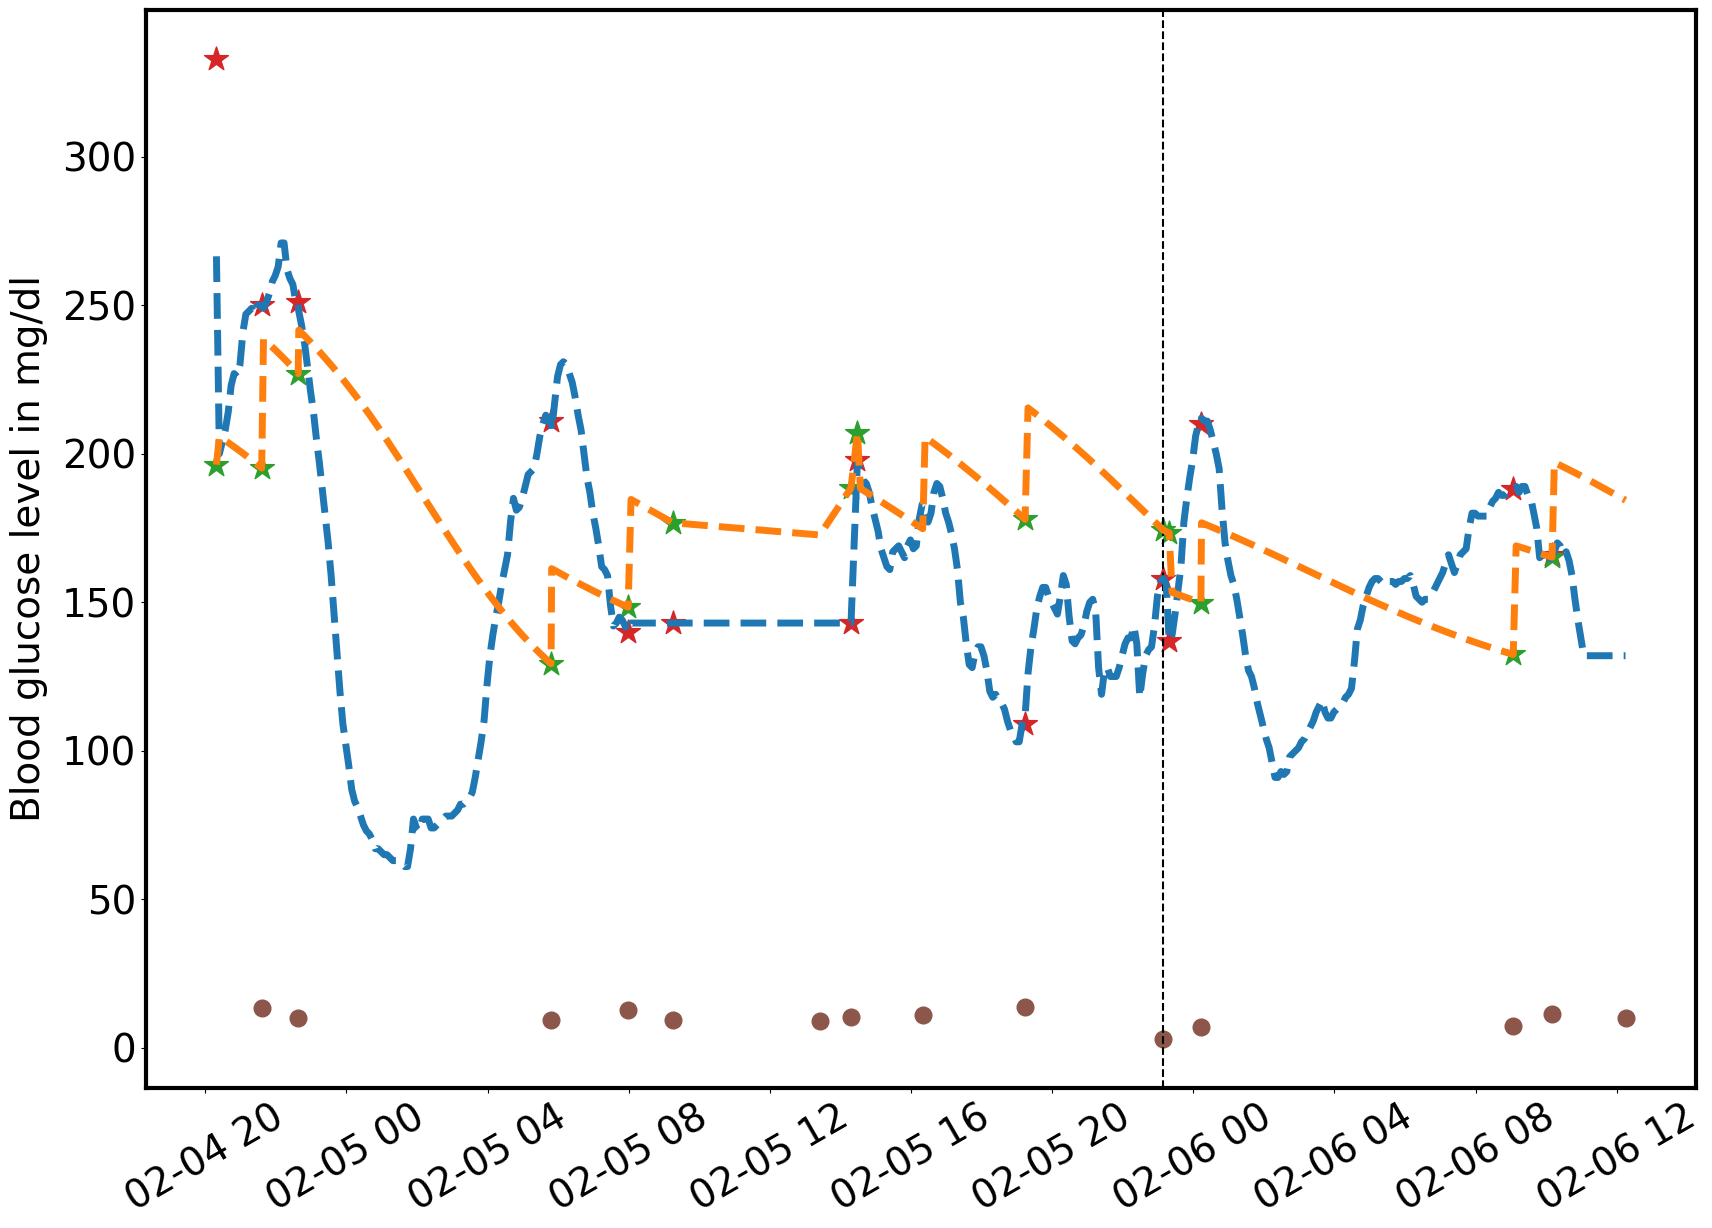

In [31]:
model = 'union'
p = 567
result = pickle.load(open(f'./results/pickles/result_{model}_{p}.pkl', 'rb'))
idx = np.random.choice(len(result['df']), 1)[0]
fig, ax = plt.subplots(figsize =(20, 14))
sample, infer_start_time, loss = show_sample_fig_cgm(result, idx, ax)
plt.show()